In [22]:
import sys
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import glob

In [23]:
df = pd.read_csv('pre_proc_data_pt.csv', sep=',')

/usr/local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3553: DtypeWarning: Columns (0,1,4,5,12) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [24]:
df = pd.concat(map(pd.read_csv, glob.glob('data/*.csv')))

In [25]:
df.count()

text               4911285
created_at         4885421
text_sentiment     4943520
sentiment_value    4943520
dtype: int64

In [26]:
df['date'] = df['created_at'].apply(
    lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S').strftime('%Y-%m-%d') if isinstance(x, str) else 0
)
df['date'] = pd.to_datetime(df['date'])
df = df[df["date"] >= '2019-11-01']

In [27]:
df.head()

,text,created_at,text_sentiment,sentiment_value,date
0,O silêncio da undb sobre o caso de COVID é ens...,2021-11-23 23:07:25,"{'neg': 0.239, 'neu': 0.761, 'pos': 0.0, 'comp...",-0.2960,2021-11-23
1,RT @tnbrasiloficial: NÃO É MAIS SEGURO VIAJAR ...,2021-11-23 23:07:23,"{'neg': 0.232, 'neu': 0.56, 'pos': 0.208, 'com...",0.0772,2021-11-23
2,@Medicina_CFM @HospSaoCamiloSP @proconspoficia...,2021-11-23 23:07:23,"{'neg': 0.035, 'neu': 0.791, 'pos': 0.174, 'co...",0.7430,2021-11-23
3,HESE inicia terceira fase da vacinação de prof...,2021-11-23 23:07:22,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,2021-11-23
4,Já botei todos meus FIIs triggers com preços p...,2021-11-23 23:07:20,"{'neg': 0.113, 'neu': 0.839, 'pos': 0.047, 'co...",-0.2023,2021-11-23


In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4762981 entries, 0 to 9999
Data columns (total 5 columns):
 #   Column           Dtype         
---  ------           -----         
 0   text             object        
 1   created_at       object        
 2   text_sentiment   object        
 3   sentiment_value  float64       
 4   date             datetime64[ns]
dtypes: datetime64[ns](1), float64(1), object(3)
memory usage: 218.0+ MB


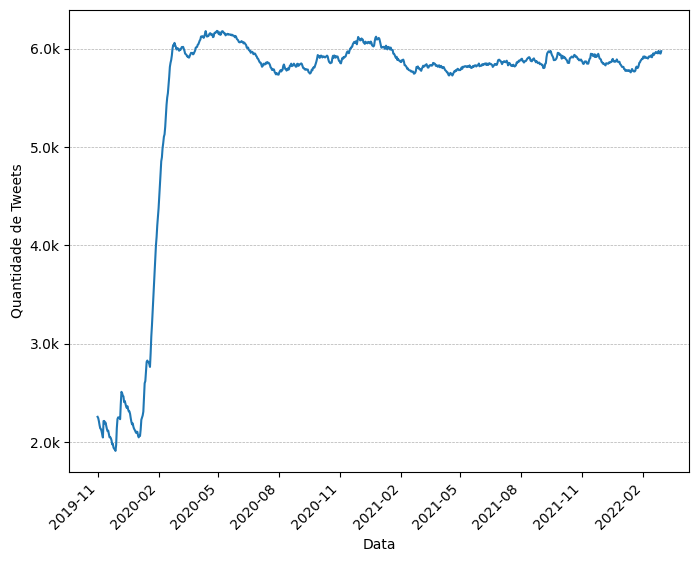

In [29]:
from matplotlib.ticker import FuncFormatter
import matplotlib.dates as mdates

from typing import List

def smooth(scalars: List[float], weight: float) -> List[float]:  # Weight between 0 and 1
    last = scalars[0]  # First value in the plot (first timestep)
    smoothed = list()
    for point in scalars:
        smoothed_val = last * weight + (1 - weight) * point  # Calculate smoothed value
        smoothed.append(smoothed_val)                        # Save it
        last = smoothed_val                                  # Anchor the last smoothed value
        
    return smoothed


def thousands(x, pos):
    'The two args are the value and tick position'
    return '%1.1fk' % (x*1e-3)

formatter = FuncFormatter(thousands)

fig, ax = plt.subplots(figsize = (8, 6))

df_ = df["date"].groupby(df["date"]).count().reset_index(name ='quantity')
df_

plt.xlabel("Data")
plt.ylabel("Quantidade de Tweets")
plt.grid(axis = 'y', linestyle = '--', linewidth = 0.5)
half_year_locator = mdates.MonthLocator(interval=3)
year_month_formatter = mdates.DateFormatter("%Y-%m") # four digits for year, two for month
ax.xaxis.set_major_locator(half_year_locator)
ax.xaxis.set_major_formatter(year_month_formatter) # formatter for major axis only
ax.yaxis.set_major_formatter(formatter)
plt.xticks(rotation=45, ha='right')
ax.plot(df_['date'], smooth(df_['quantity'], 0.95))

In [30]:
df['sentiment'] = df.apply(lambda x: 'Negativo' if x['sentiment_value'] <= -.05 else 'Positivo' if x['sentiment_value'] >= .05 else 'Neutro', axis=1)

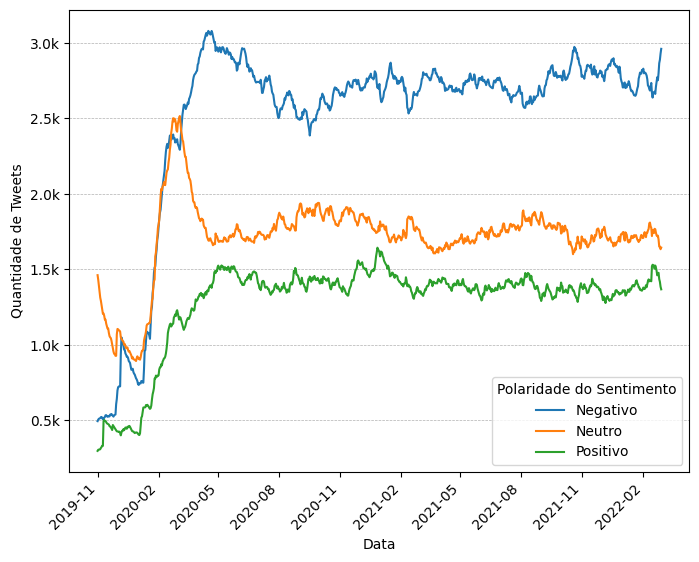

In [31]:
from matplotlib.ticker import FuncFormatter
from typing import List

def smooth(scalars: List[float], weight: float) -> List[float]:  # Weight between 0 and 1
    last = scalars[0]  # First value in the plot (first timestep)
    smoothed = list()
    for point in scalars:
        smoothed_val = last * weight + (1 - weight) * point  # Calculate smoothed value
        smoothed.append(smoothed_val)                        # Save it
        last = smoothed_val                                  # Anchor the last smoothed value
        
    return smoothed


def thousands(x, pos):
    'The two args are the value and tick position'
    return '%1.1fk' % (x*1e-3)

formatter = FuncFormatter(thousands)

fig, ax = plt.subplots(figsize = (8, 6))

df_ = df[["date", "sentiment"]].groupby(["date", "sentiment"]).size().reset_index(name ='quantity').pivot(index='date', columns='sentiment', values='quantity').reset_index()
df_

plt.xlabel("Data")
plt.ylabel("Quantidade de Tweets")
plt.grid(axis = 'y', linestyle = '--', linewidth = 0.5)
half_year_locator = mdates.MonthLocator(interval=3)
year_month_formatter = mdates.DateFormatter("%Y-%m") # four digits for year, two for month
ax.xaxis.set_major_locator(half_year_locator)
ax.xaxis.set_major_formatter(year_month_formatter) # formatter for major axis only
ax.yaxis.set_major_formatter(formatter)
plt.xticks(rotation=45, ha='right')

num=0
for column in df_.drop('date', axis=1):
    num+=1
    plt.plot(df_['date'], smooth(df_[column], 0.95), marker='', label=column)
ax.legend(title="Polaridade do Sentimento")

In [32]:
df[["date", "sentiment"]].groupby(["date", "sentiment"]).size().reset_index(name ='quantity').pivot(index='date', columns='sentiment', values='quantity').reset_index()

sentiment,date,Negativo,Neutro,Positivo
0,2019-11-01,495,1462,298
1,2019-11-02,699,834,448
2,2019-11-03,624,653,332
3,2019-11-04,540,553,310
4,2019-11-05,567,611,356
...,...,...,...,...
846,2022-02-24,3706,1211,1516
847,2022-02-25,4114,753,644
848,2022-02-26,3300,1673,1083
849,2022-02-27,3715,1290,773


(array([  22626.,   77417.,  116255.,  146011.,  151110.,  191666.,
         165075.,  204571.,  242439.,  151947.,  305603.,  102596.,
         194965.,   84635.,   69775., 1450287.,  107156.,   69943.,
          88562.,  135247.,  128351.,  161602.,   98039.,   76573.,
          80892.,   56894.,   44667.,   23991.,   11682.,    2404.]),
 array([-9.98700000e-01, -9.32126667e-01, -8.65553333e-01, -7.98980000e-01,
        -7.32406667e-01, -6.65833333e-01, -5.99260000e-01, -5.32686667e-01,
        -4.66113333e-01, -3.99540000e-01, -3.32966667e-01, -2.66393333e-01,
        -1.99820000e-01, -1.33246667e-01, -6.66733333e-02, -1.00000000e-04,
         6.64733333e-02,  1.33046667e-01,  1.99620000e-01,  2.66193333e-01,
         3.32766667e-01,  3.99340000e-01,  4.65913333e-01,  5.32486667e-01,
         5.99060000e-01,  6.65633333e-01,  7.32206667e-01,  7.98780000e-01,
         8.65353333e-01,  9.31926667e-01,  9.98500000e-01]),
 <BarContainer object of 30 artists>)

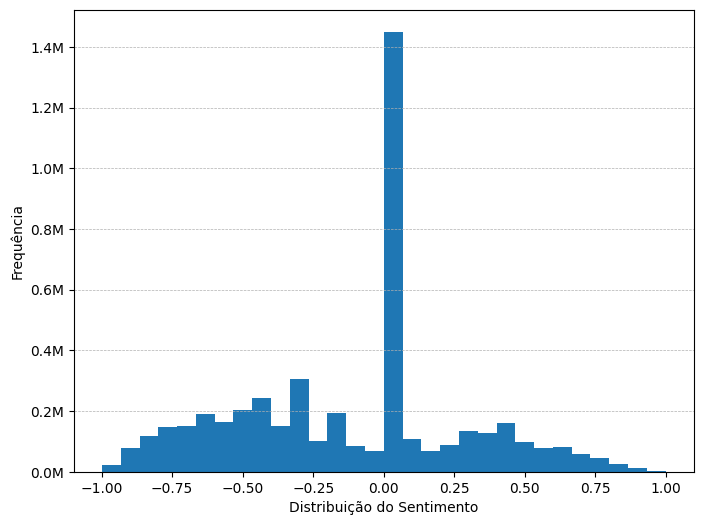

In [33]:
from matplotlib.ticker import FuncFormatter

def thousands(x, pos):
    'The two args are the value and tick position'
    return '%1.1fM' % (x*1e-6)

formatter = FuncFormatter(thousands)

fig, ax = plt.subplots(figsize = (8, 6))
plt.xlabel("Distribuição do Sentimento")
plt.ylabel("Frequência")
plt.grid(axis = 'y', linestyle = '--', linewidth = 0.5)
ax.yaxis.set_major_formatter(formatter)
ax.hist(df['sentiment_value'], bins=30)

### Filtrando neutro

(array([  5434.,  27968.,  48312.,  61960.,  72624.,  77122.,  93215.,
        103910.,  77887., 136653.,  76084., 145114., 101431., 122552.,
        166904., 100954.,  56936., 270806.,  62479.,  68971.,  32218.,
        192450.,  30826.,  51601.,      0.,      0.,  82484.,  28880.,
         56602.,  38160.,  58338.,  85374.,  77533.,  48003.,  82912.,
         80296., 106279.,  51864.,  57617.,  40158.,  57758.,  35448.,
         38005.,  27518.,  23724.,  15604.,  11924.,   7030.,   3046.,
           473.]),
 array([-9.98700e-01, -9.58756e-01, -9.18812e-01, -8.78868e-01,
        -8.38924e-01, -7.98980e-01, -7.59036e-01, -7.19092e-01,
        -6.79148e-01, -6.39204e-01, -5.99260e-01, -5.59316e-01,
        -5.19372e-01, -4.79428e-01, -4.39484e-01, -3.99540e-01,
        -3.59596e-01, -3.19652e-01, -2.79708e-01, -2.39764e-01,
        -1.99820e-01, -1.59876e-01, -1.19932e-01, -7.99880e-02,
        -4.00440e-02, -1.00000e-04,  3.98440e-02,  7.97880e-02,
         1.19732e-01,  1.59676e-01, 

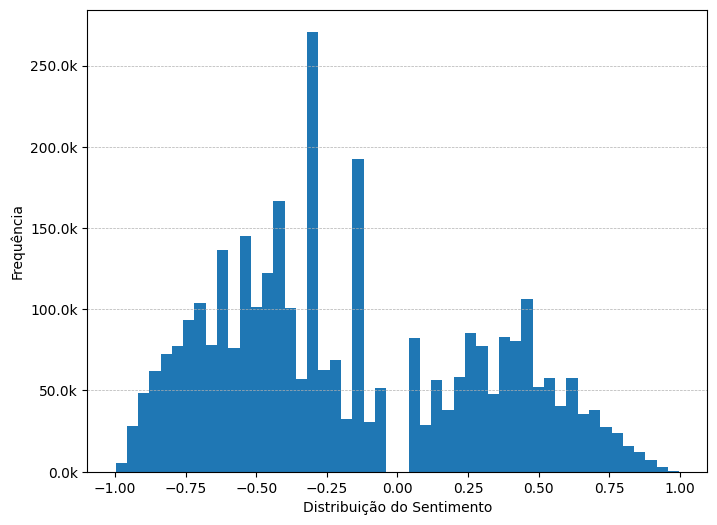

In [34]:
df_ = df[df['sentiment'] != 'Neutro']

def thousands(x, pos):
    'The two args are the value and tick position'
    return '%1.1fk' % (x*1e-3)

formatter = FuncFormatter(thousands)

fig, ax = plt.subplots(figsize = (8, 6))
plt.xlabel("Distribuição do Sentimento")
plt.ylabel("Frequência")
plt.grid(axis = 'y', linestyle = '--', linewidth = 0.5)
ax.yaxis.set_major_formatter(formatter)
ax.hist(df_['sentiment_value'], bins=50)

In [35]:
df_.count()

text               3299441
created_at         3299441
text_sentiment     3299441
sentiment_value    3299441
date               3299441
sentiment          3299441
dtype: int64

(array([ 49000., 146988., 205022., 230966., 291361., 236718., 308870.,
        339420., 262347., 113719.]),
 array([-0.9987 , -0.90383, -0.80896, -0.71409, -0.61922, -0.52435,
        -0.42948, -0.33461, -0.23974, -0.14487, -0.05   ]),
 <BarContainer object of 10 artists>)

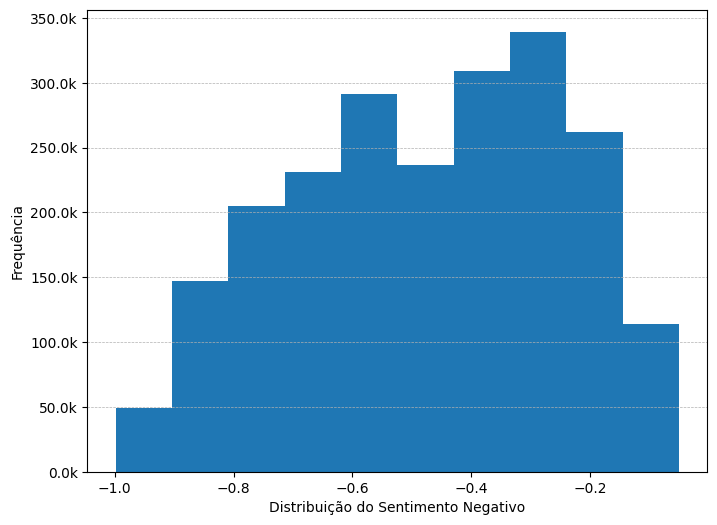

In [36]:
df_ = df[(df['sentiment'] == 'Negativo')]

def thousands(x, pos):
    'The two args are the value and tick position'
    return '%1.1fk' % (x*1e-3)

formatter = FuncFormatter(thousands)

fig, ax = plt.subplots(figsize = (8, 6))
plt.xlabel("Distribuição do Sentimento Negativo")
plt.ylabel("Frequência")
plt.grid(axis = 'y', linestyle = '--', linewidth = 0.5)
ax.yaxis.set_major_formatter(formatter)
ax.hist(df_['sentiment_value'], bins=10)

(array([142241., 122226., 165830., 204083., 164176., 119996., 102502.,
         60729.,  27319.,   5928.]),
 array([0.0504 , 0.14521, 0.24002, 0.33483, 0.42964, 0.52445, 0.61926,
        0.71407, 0.80888, 0.90369, 0.9985 ]),
 <BarContainer object of 10 artists>)

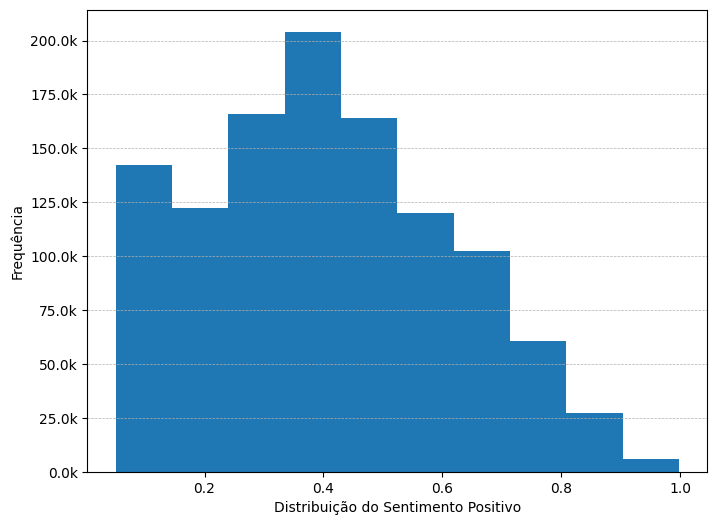

In [37]:
df_ = df[(df['sentiment'] == 'Positivo')]

def thousands(x, pos):
    'The two args are the value and tick position'
    return '%1.1fk' % (x*1e-3)

formatter = FuncFormatter(thousands)

fig, ax = plt.subplots(figsize = (8, 6))
plt.xlabel("Distribuição do Sentimento Positivo")
plt.ylabel("Frequência")
plt.grid(axis = 'y', linestyle = '--', linewidth = 0.5)
ax.yaxis.set_major_formatter(formatter)
ax.hist(df_['sentiment_value'], bins=10)

In [40]:
df.groupby('sentiment').size()

sentiment
Negativo    2184411
Neutro      1463540
Positivo    1115030
dtype: int64

In [42]:
tot = 2184411+1463540+1115030
tot

4762981

In [43]:
2184411/tot

0.4586226566933607

In [45]:
1463540/tot

0.30727395301387933

In [44]:
1115030/tot

0.23410339029275992